# ISDS 7070 Machine Learning Project

## Chronic Heart Disease Predictive Model

#### Imports

In [29]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
!pip install -U pandasql
import pandasql as ps
from pandasql import sqldf
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score

#### Data Overview

In [30]:
file = pd.read_csv('heartdisease.csv')

In [31]:
display(file)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [32]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


#### Data Wrangling

For the columns of glucse, totCHol, BMI, and heartRate, the missing entries are replaced by the mean value of those columns.

In [33]:
avg_glucose = file['glucose'].astype('float').mean()
file["glucose"].replace(np.nan, avg_glucose, inplace=True)

avg_totChol = file['totChol'].astype('float').mean()
file["totChol"].replace(np.nan, avg_totChol, inplace=True)

avg_BMI = file['BMI'].astype('float').mean()
file["BMI"].replace(np.nan, avg_BMI, inplace=True)

avg_heartRate = file['heartRate'].mean()
file["heartRate"].replace(np.nan, avg_heartRate, inplace=True)

For the columns of education and BPMeds, the mode values replaced the missing entries of each column. 

<AxesSubplot:>

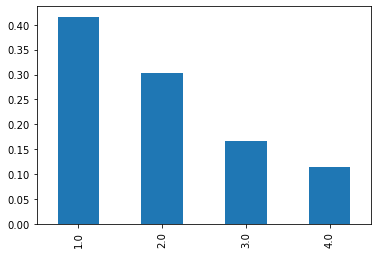

In [34]:
file['education'].value_counts(normalize = True).plot(kind="bar")

In [35]:
file["education"].replace(np.nan, '1', inplace=True)

<AxesSubplot:>

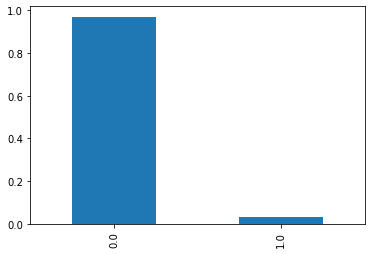

In [36]:
file['BPMeds'].value_counts(normalize = True).plot(kind="bar")

In [37]:
file["BPMeds"].replace(np.nan, "0", inplace=True)

For the cigsPerDay column, the entries that contained nonsmokers were given a 0. On the other hand, the entries that contained smokers, the missing entries were replaced by the mean value of cigsPerDay.

In [38]:
def function():
    if file["currentSmoker"] == '0':
        return '0' in file["cigsperday"]

In [39]:
pysqldf = lambda q: sqldf(q, globals())
avg_cigsperday = pysqldf("SELECT avg(cigsperday) FROM file WHERE currentSmoker = 1")
avg_cigsperday

,avg(cigsperday)
0,18.350605


In [40]:
file["cigsPerDay"].replace(np.nan, 18.350605, inplace=True)

#### Data Exploration

In order to determine the features for the model, it is necessary to determine feature importance. In determination, the following plots were used to visualize the level of importance when determining chronic heart disease.  

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

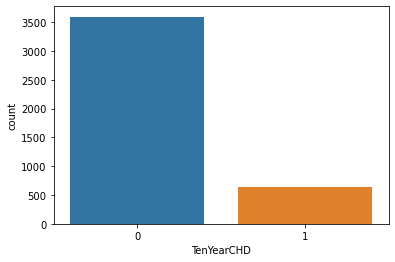

In [41]:
sns.countplot(x='TenYearCHD', data=file)

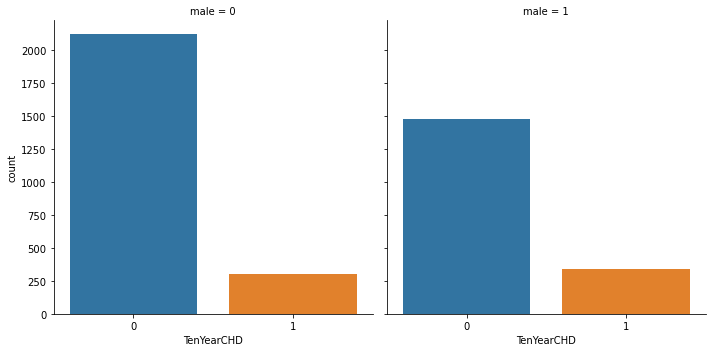

In [42]:
sns.catplot(x='TenYearCHD', col='male', kind='count', data=file);

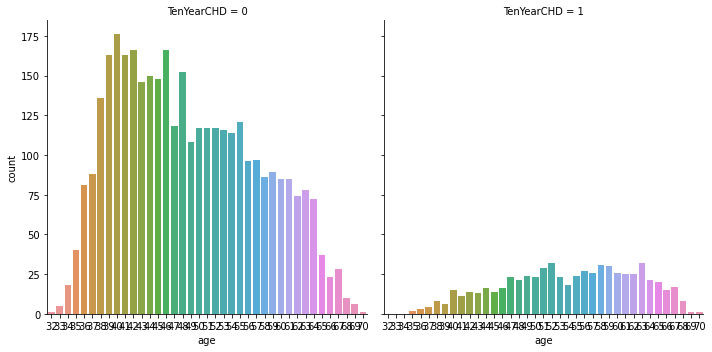

In [43]:
sns.catplot(x='age', col='TenYearCHD', kind='count', data=file);

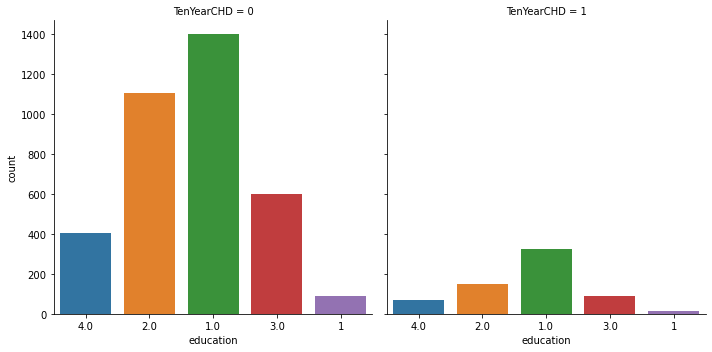

In [44]:
sns.catplot(x='education', col='TenYearCHD', kind='count', data=file);

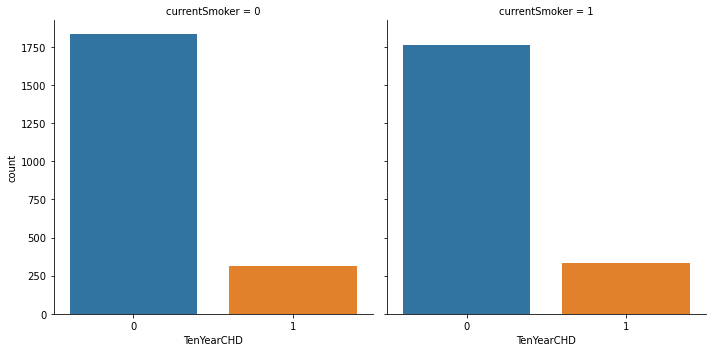

In [45]:
sns.catplot(x='TenYearCHD', col='currentSmoker', kind='count', data=file);

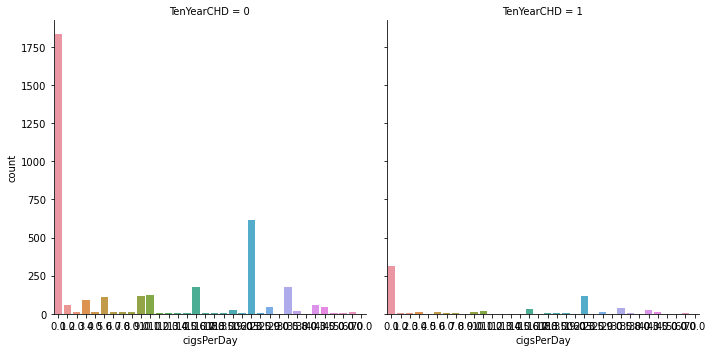

In [46]:
sns.catplot(x='cigsPerDay', col='TenYearCHD', kind='count', data=file)

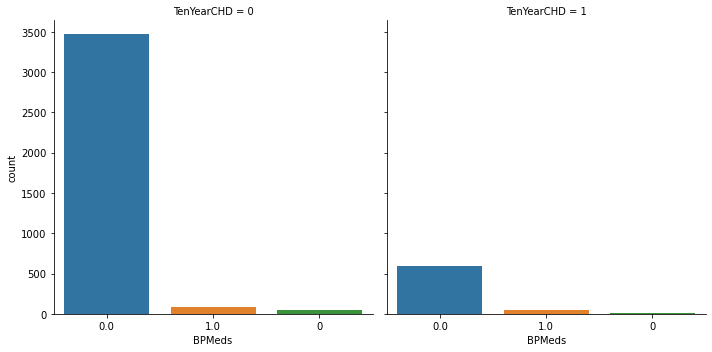

In [47]:
sns.catplot(x='BPMeds', col='TenYearCHD', kind='count', data=file);

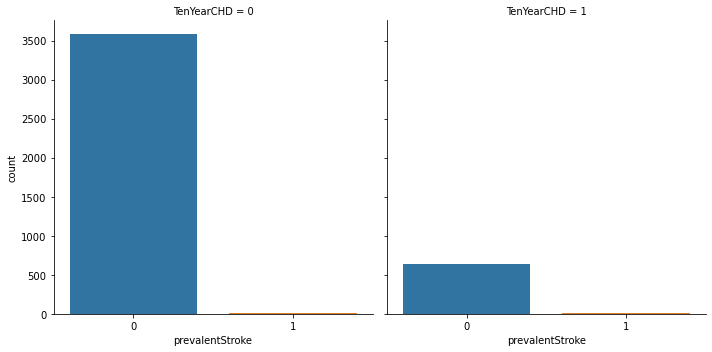

In [48]:
sns.catplot(x='prevalentStroke', col='TenYearCHD', kind='count', data=file);

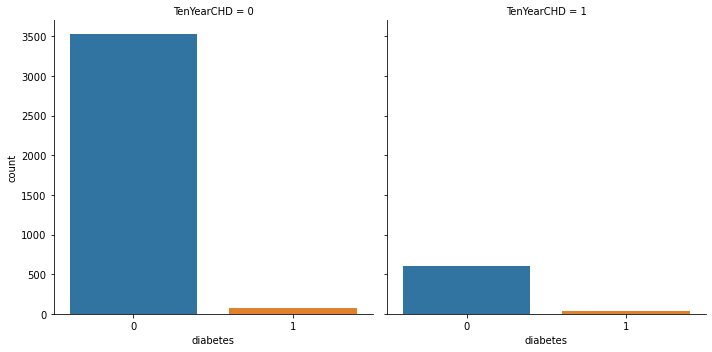

In [49]:
sns.catplot(x='diabetes', col='TenYearCHD', kind='count', data=file);

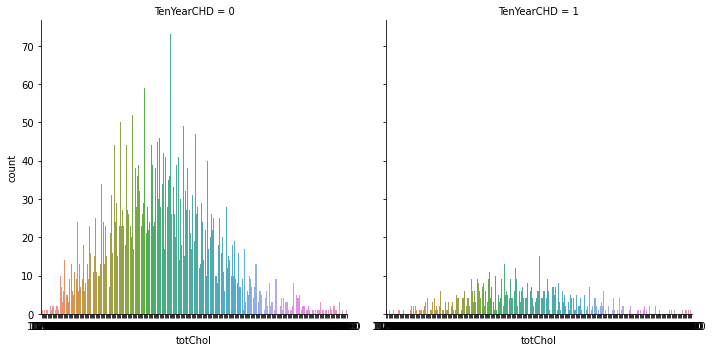

In [50]:
sns.catplot(x='totChol', col='TenYearCHD', kind='count', data=file);

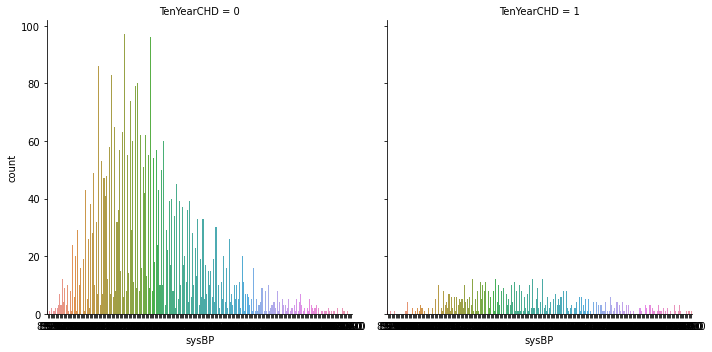

In [51]:
sns.catplot(x='sysBP', col='TenYearCHD', kind='count', data=file);

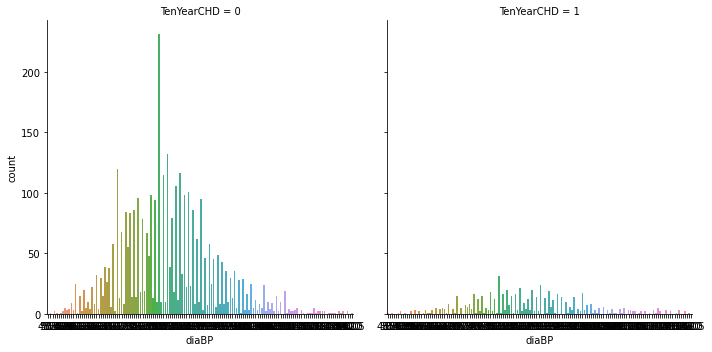

In [52]:
sns.catplot(x='diaBP', col='TenYearCHD', kind='count', data=file);

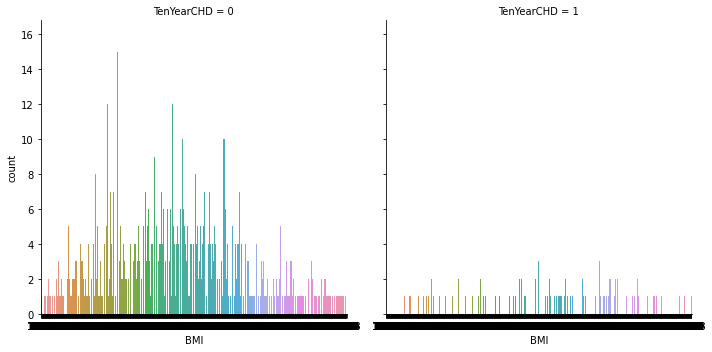

In [53]:
sns.catplot(x='BMI', col='TenYearCHD', kind='count', data=file);

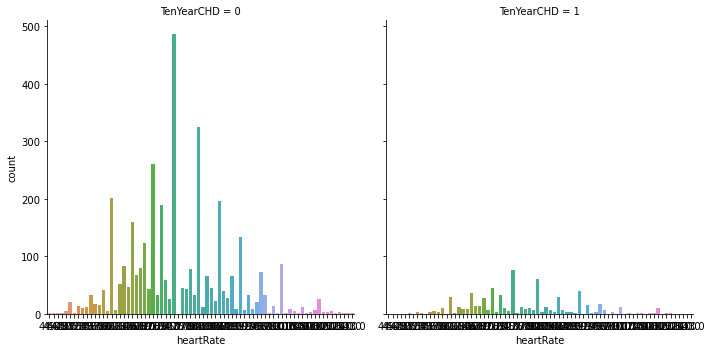

In [54]:
sns.catplot(x='heartRate', col='TenYearCHD', kind='count', data=file);

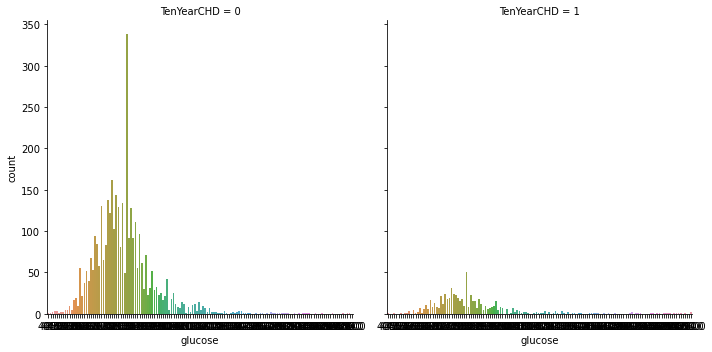

In [55]:
sns.catplot(x='glucose', col='TenYearCHD', kind='count', data=file);

From the appearance of these plots to the naked eye, the features are not showing much of a difference between those who get chronic heart disease and those who do not. Due to this, a heat map was plotted to determine the coorelation of features within the data.

<AxesSubplot:>

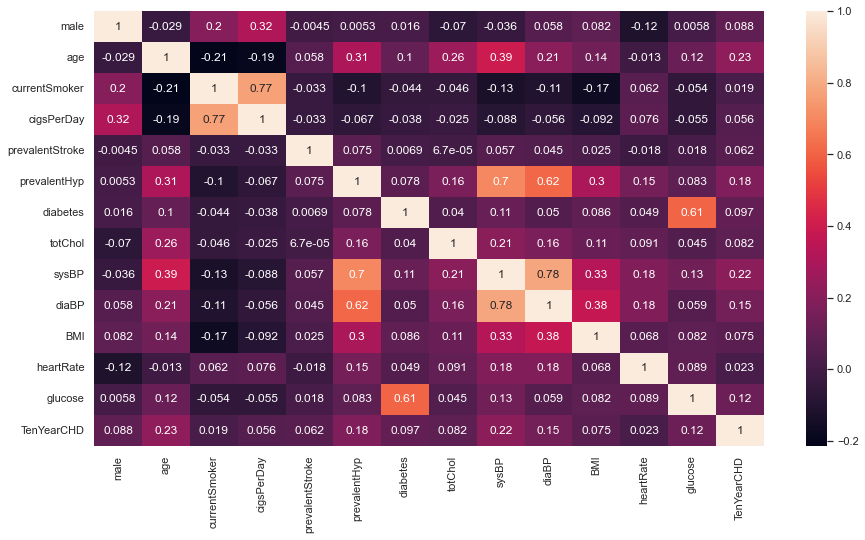

In [56]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(file.corr(), annot=True)

#### Creation of the Predictive Model

Through the use of sea

In [57]:
x = file[['age', 'sysBP', 'totChol', 'BMI', 'heartRate', 'glucose']]
y = file[['TenYearCHD']]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 14)

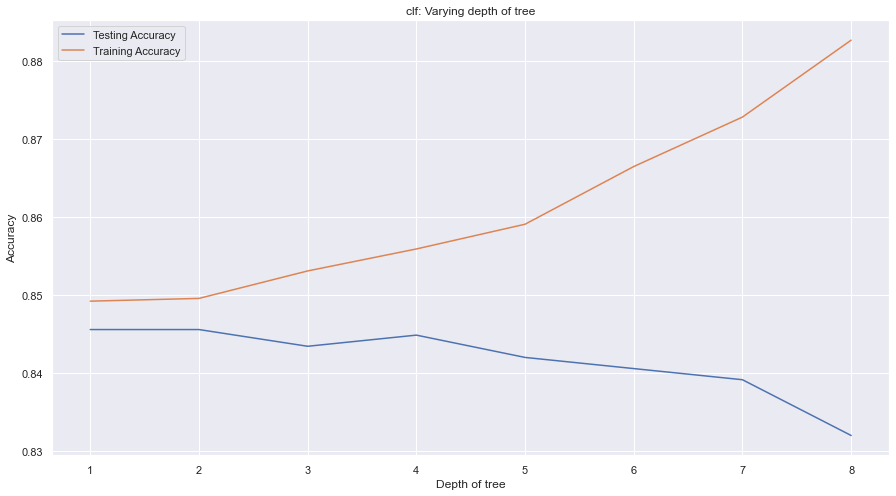

In [59]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(x_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(x_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [66]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, bootstrap=True)
model.fit(x_train, y_train)

/var/folders/p1/x94ztrv14m7cgmflgf4gm2jw0000gn/T/ipykernel_4691/1230203479.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestClassifier(max_depth=4)

In [67]:
# model.predict(X_test)
y_pred = model.predict(x_test)

In [68]:
# The mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test, y_pred)
print('R-Squared:', r2)

Mean squared error: 0.15511079342387418
R-Squared: -0.1880615822923517
